## Clustering visualization

This notebook will be used for the visualization of the subspace-defining cluster using different techniques and under different clusterings.

We will load an existing clustering and then visualize it using different techniques.

In [1]:
# Include and load packages, config files

import numpy as np
import simlr_ad
import pandas as pd
from utils.data_utils import load_all_data
from utils.utils import compute_simlr, feat_ranking, estimate_number_clusters
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Parameters of the procedure
clusters = 3
rd_seed = 1714                                          # Random seed for experiment replication

# Paths
existing_cluster = True                               # Compute the clustering again or use an existing one
cluster_path = "results/extendeddata_cluster/"   # Path of the existing cluster, if applicable
covariate_path = "data/useddata_homo_abeta_plasma_meta.csv"                 # Path of the covariance data frame (.csv)
feature_path = "data/UCSDVOL.csv"                     # Path of the feature path (.csv)

covariate_data, cov_names, feature_data, feature_names = load_all_data(covariate_path, feature_path)
feature_data['DX'] = covariate_data.DX_bl.values

if existing_cluster:
    # Load existent
    c_data = pd.read_csv(cluster_path + 'cluster_data.csv')
    c_data.reset_index(inplace=True)

    ## Load S, F data
    S = np.load(cluster_path + 'S_matrix.npy')
    ydata = np.load(cluster_path + 'ydata_matrix.npy')
    F = np.load(cluster_path + 'F_matrix.npy')
else:
    # Compute base clustering
    y_b, S, F, ydata, alpha = compute_simlr(
        np.array(covariate_data[cov_names]), clusters)

# Preprocess S matrix

S_old = (S - min(S.flatten())) / (max(S.flatten())-min(S.flatten())) 
S = (1-S_old)
from sklearn.metrics.pairwise import euclidean_distances
S_euclidean = euclidean_distances(covariate_data[cov_names], covariate_data[cov_names])
S_euc_new = (1-S_euclidean)

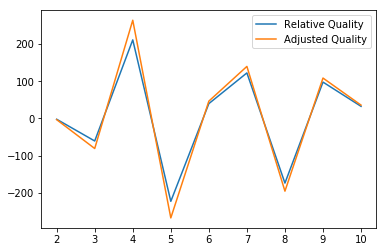

In [2]:
# Visualize possible number of clusters
K1, K2, n_list = estimate_number_clusters(np.array(covariate_data[cov_names]))

plt.plot(n_list, K1, label='Relative Quality')
plt.plot(n_list, K2, label='Adjusted Quality')
plt.legend()
plt.savefig("clusternumber.png")
plt.show()

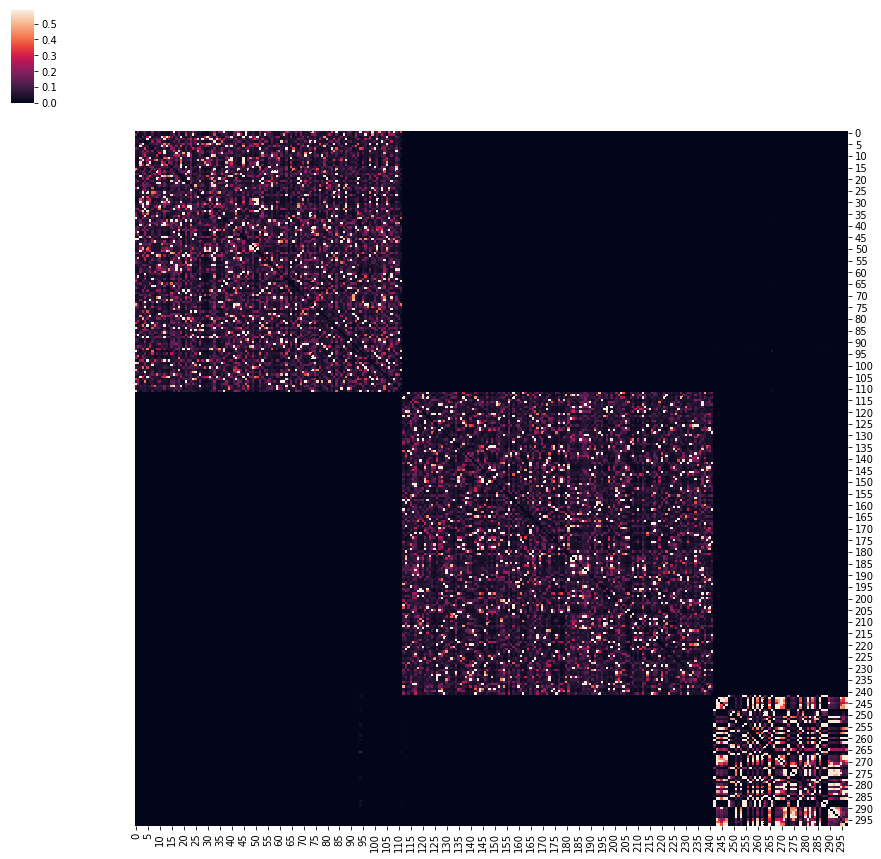

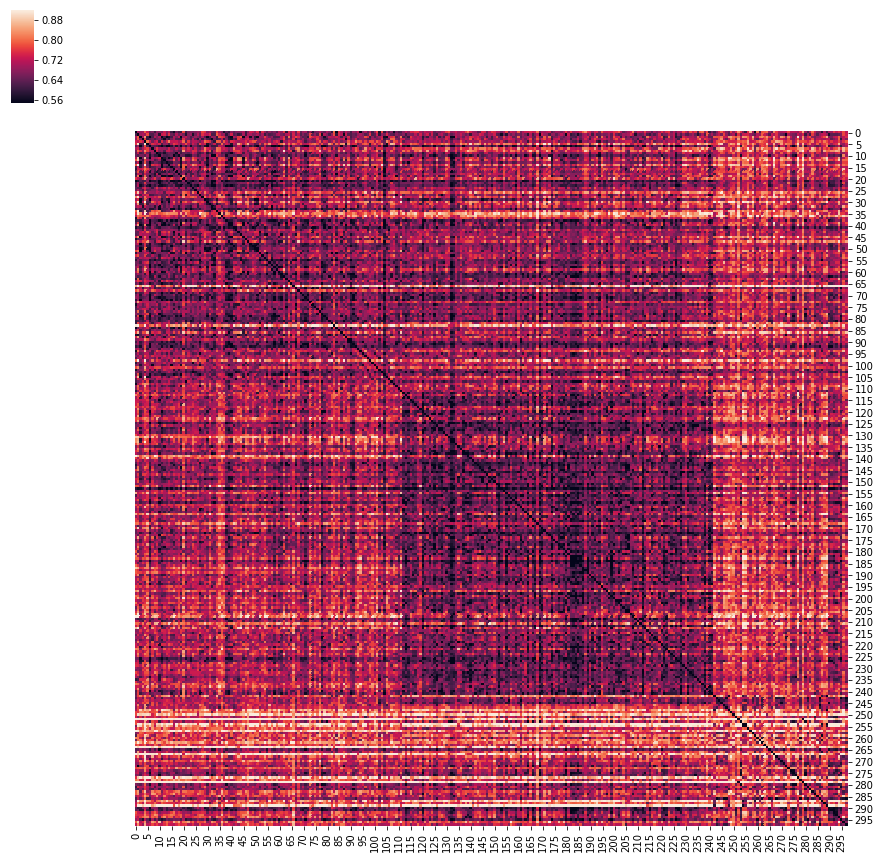

In [3]:
## Visualize the similarity matrix

# Sort the similarity matrices using the clustering labels
c_data_sorted = c_data.sort_values(['C'])
index = c_data_sorted.index.values

S_old = S_old[index, :]
S_old = S_old[:, index]

S_euclidean = S_euclidean[index, :]
S_euclidean = S_euclidean[:, index]

sns.clustermap(S_old, col_cluster=False, row_cluster=False, robust=True,
               method='average', metric='seuclidean', standard_scale=1, figsize=(15, 15))
plt.savefig('Cluster_Simlr.png')
plt.show()

sns.clustermap(S_euclidean, col_cluster=False, row_cluster=False, robust=True,
               method='average', metric='seuclidean', standard_scale=1, figsize=(15, 15))
plt.savefig('Cluster_euclidean.png')
plt.show()


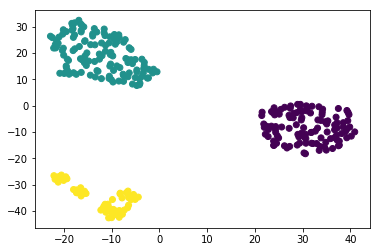

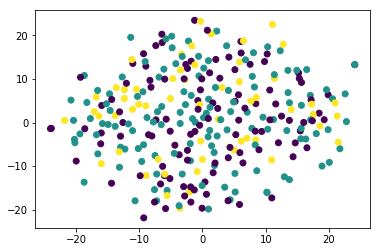

In [4]:
## Use t-SNE to visualize the clusters
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# test different parameters!
ts = TSNE(n_components=2, perplexity = 15.0, early_exaggeration = 30.0, learning_rate = 100.0, metric='precomputed')
space = ts.fit_transform(S)
plt.scatter(space[:, 0], space[:, 1], c=c_data['C'].values)
plt.axis('tight')
plt.savefig('simlr_tsne.png')
plt.show()

# test different parameters!
ts = TSNE(n_components=2, perplexity = 15.0, early_exaggeration = 30.0, learning_rate = 100.0, metric='precomputed')
space = ts.fit_transform(S_euclidean)
plt.scatter(space[:, 0], space[:, 1], c=c_data['C'].values)
plt.axis('tight')
plt.savefig('euclidean_tsne.png')
plt.show()

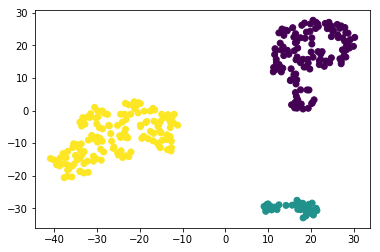

In [4]:
## Use Spectral clustering
from sklearn.manifold import SpectralEmbedding 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure()
spec = SpectralEmbedding(n_components=2, affinity='precomputed')
lel = ts.fit_transform(S)
plt.scatter(lel[:, 0], lel[:, 1], c=c_data['C'].values)
plt.axis('tight')
plt.show()